# Clustering task

In [2]:
# Loading and data manipulation
import pandas as pd
from pandas.api.types import is_numeric_dtype

# Numerical computing
import numpy as np

# Data preprocessing and decomposition
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA

# Clustering task
from scipy.spatial.distance import cdist
from sklearn.cluster import OPTICS, cluster_optics_dbscan 
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import *

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec 
from matplotlib.colors import ListedColormap
import seaborn as sns

In [3]:
font = {
    'family': 'arial',
    'size': 13,
    'weight': 'bold'
}

plt.rc('font', **font)

In [4]:
import warnings

warnings.filterwarnings('ignore')

## Loading dataset

In [6]:
data = pd.read_csv('input/StudentPerformanceFactors_filtered.csv', 
                   engine='python')

In [7]:
pd.set_option('display.max_columns', 5)

print(data)

      Hours_Studied  Attendance  ... Exam_Score    Perf
0                23          84  ...         67     Low
1                19          64  ...         61     Low
2                24          98  ...         74  Medium
3                29          89  ...         71  Medium
4                19          92  ...         70     Low
...             ...         ...  ...        ...     ...
6602             25          69  ...         68     Low
6603             23          76  ...         69     Low
6604             20          90  ...         68     Low
6605             10          86  ...         68     Low
6606             15          67  ...         64     Low

[6607 rows x 7 columns]


## Data preprocessing

We transform raw data into an understandable and useful format.

### Converting object columns to numeric where possible

In [11]:
def cat_to_num(data: pd.DataFrame) -> pd.DataFrame:
    for feature in data.columns:
        if is_numeric_dtype(data[feature]) is False:
            data[feature] = data[feature].astype('category').cat.codes

    return data

In [12]:
pd.set_option('display.max_columns', 5)

cat_to_num(data=data)
print(data)

      Hours_Studied  Attendance  ...  Exam_Score  Perf
0                23          84  ...          67     1
1                19          64  ...          61     1
2                24          98  ...          74     2
3                29          89  ...          71     2
4                19          92  ...          70     1
...             ...         ...  ...         ...   ...
6602             25          69  ...          68     1
6603             23          76  ...          69     1
6604             20          90  ...          68     1
6605             10          86  ...          68     1
6606             15          67  ...          64     1

[6607 rows x 7 columns]


In [13]:
X, Y = data.iloc[:, :-1].values, \
        data.iloc[:, -1:].values

### Reducing dimensionality and extracting important features from the dataset

In order to reduce data dimensionality we implement the PCA approach. The PCA is an unsupervised linear transformation technique that is widely used across different fields, most prominently for feature extraction and dimensionality reduction.

Firstall, we standardize the data

$$Z = \frac{X - \mu_X}{\sigma_X}$$

where $\mu_X$ and $\sigma_X$ are the mean and the standard deviation of independent features respectively.

In [16]:
m, s = X.mean(axis=0), X.std(axis=0)
Z = (X - m)/s

In order to compute eigendecomposition we need to make the covariance matrix. So we construct the covariance matrix and from it we calculate the eigenvalues and the eigenvectors.

$$\Sigma = 
\begin{bmatrix} 
\sigma^{2}_{0} & \sigma_{01} & \cdots & \sigma_{0n} \\ 
\sigma_{10} & \sigma^{2}_{1} & \cdots & \sigma_{1n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n0} & \sigma_{n1} & \cdots & \sigma^{2}_{n}
\end{bmatrix}$$

where $\Sigma$ is the variance-covariance matrix, a square matrix with diagonal elements that represent the variance and the non-diagonal components that express covariance.

In [18]:
cov_mat = np.cov(Z.T)

Let $A$ be a square $n \times n$ matrix and $X$ be a non-zero vector for which:

$$AX = \lambda X$$

where $\lambda$ is known as the eigenvalue of matrix $A$, and $X$ the eigenvector of matrix $A$ for the corresponding eigenvalue. So, we can find the eigenvalues $\lambda$ and therefore corresponding eigenvector can be found using the above mentioned equation. 

In [20]:
# From the covariance matrix, computes the Eigenvalues and the Eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

Afterwords, we sort the eigenvalues by decreasing order to rank the eigenvectors and cumulate them to figure out how many principal components are we going to use.

In [22]:
tot = sum(eigen_vals)
# explained variance ratio
# = pca.explained_variance_ / np.sum(pca.explained_variance_)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]

cum_var_exp = np.cumsum(var_exp)

Vectors in $X$ point to biggest directions of variance, also known as principal components (i.e. principal directions).

It is sometimes thought that a good factor analysis should explain at least two-thirds of the variance.

In [25]:
no_components = np.argmax(cum_var_exp >= 2/3)

print(f'{no_components} principal components')

3 principal components


In [26]:
print(f'''From the output, we observe that 
 \033[1m{100*var_exp[0]:.2f}%\033[0m of the dataset’s variance lies along the 1-st component,
 \033[1m{100*var_exp[1]:.2f}%\033[0m lies along the 2-nd component, 
 \033[1m{100*var_exp[2]:.2f}%\033[0m lies along the 3-th component''')

From the output, we observe that 
 28.92% of the dataset’s variance lies along the 1-st component,
 17.03% lies along the 2-nd component, 
 16.88% lies along the 3-th component


The first three components explain <strong>≈63%</strong> of the overall variability, while the rest of the components explain smaller quantities that softly vary, which refers that the first three components should be kept.

In [28]:
# compare my standardization vs standard scaler of sklearn  

scaler = StandardScaler()
XSTDSL = scaler.fit_transform(X)

all([any(x==z) for x, z in zip(XSTDSL, Z)])

True

In [29]:
# compare my PCA vs PCA of sklearn 

Pca = PCA().fit(XSTDSL)
XSC = Pca.transform(XSTDSL)

print(any([(round(x, 5) == round(y, 5)) for x, y in zip(Pca.explained_variance_ratio_, var_exp)]))

del scaler, XSTDSL, Pca

True


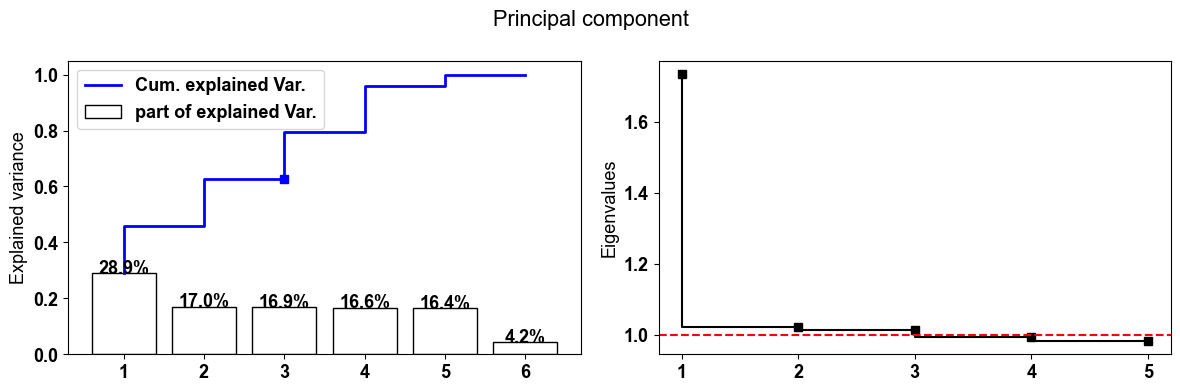

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axs[0].bar(range(1, len(var_exp)+1), var_exp, color='w', edgecolor='k', label='part of explained Var.')
axs[0].set_ylabel('Explained variance')
axs[0].set_xticks(range(1, Z.shape[1]+1, 1))

# vertical bars
for i in range(len(var_exp)):
    axs[0].text(i+1, var_exp[i], f'{100*var_exp[i]:.1f}%', ha='center')

axs[0].step(range(1, len(var_exp)+1), cum_var_exp, c='b', lw=2, label='Cum. explained Var.', where='pre')
axs[0].plot(no_components, cum_var_exp[no_components-1], marker='s', c='b')
axs[0].set_xticks(range(1, len(var_exp)+1, 1))
axs[0].legend()

axs[1].step(range(1, len(var_exp)), sorted(eigen_vals, reverse=True)[:-1], 'ks-')
axs[1].set_xticks(range(1, len(var_exp), 1))
axs[1].set_ylabel('Eigenvalues')
axs[1].axhline(1, c='r', linestyle='--')


plt.suptitle('Principal component')
plt.tight_layout()
plt.show();

The plot on the right shows the eigenvalues with a horizontal line intersecting the y-axis at 1, to see which PCs have eigenvalues greater than 1. These equal to the first three components according to the _Kaiser’s rule_ (_choosing only PCs with eigenvalues_ > 1).

After learning the steps of PCA, we can let sklearn to elaborate the computation.

In [32]:
# Scaling the data to bring all the attributes to a comparable level 
scal = StandardScaler() 
Xstd = scal.fit_transform(X) 

In [33]:
pca = PCA(n_components=no_components).fit(Xstd)
X = pca.transform(Xstd)

## Implementing OPTICS model

Ordering Points To Identify the Clustering Structure (OPTICS) is an algorithm for density based clustering. It is similar to the DBSCAN algorithm for clustering, an extension even, and hence borrows some of its components as well as its algorithmic components.

__The components__
- __epsilon__ it is a distance parameter in the sense that for any point $p$, the _epsilon_ defines a distance around the point.
- __min samples__ parameter controls the minimum number of sample points required to form a dense region.
- __cluster method__ it is the clustering-specific method will be used for extracting clusters; can be "xi" (_default_) and "dbscan".
- __metric__ metric to use for distance computation: 'minkowski' (default), 'euclidean', 'manhattan', ecc.


### Building the clustering model

In order to make clustering task, we set: the parameter epsilon equal to 0.0001, minimum number of sample points equal to 281 observed points, and euclidean metric to compute distances. We choose default cluster method ('xi'); furthermore we set parameter xi (float between 0 and 1, default=0.05) equal to the epsilon value. This parameter determines the minimum steepness on the reachability plot that constitutes a cluster boundary.

In [38]:
# Configuration options
epsilon=.0001
min_samples=281
cluster_method='xi'
metric='euclidean'

# Compute OPTICS
optics_predict = OPTICS(
    eps=epsilon, 
    min_samples=min_samples, 
    cluster_method=cluster_method, xi=epsilon,
    metric=metric)\
.fit(normalize(X))

labels_optics = optics_predict.labels_

Noisy samples points which are not included in any cluster are labeled as -1.

In [40]:
np.set_printoptions(threshold=10)

clusters = labels_optics[labels_optics != -1]
noises = labels_optics[labels_optics == -1]

print('Estimated no. of clusters: %d' % len(np.unique(clusters)), clusters)
print('Estimated no. of noise points: %d' % len(noises), noises)

Estimated no. of clusters: 3 [0 1 0 ... 0 1 2]
Estimated no. of noise points: 4709 [-1 -1 -1 ... -1 -1 -1]


### Visualizing the results

In [42]:
for p in data.Perf.unique():
    x = data.loc[data.Perf == p, 'Exam_Score']
    print(f'label perf. {p} = {x.min()}-{x.max()}')

label perf. 1 = 55-70
label perf. 2 = 71-85
label perf. 0 = 86-101


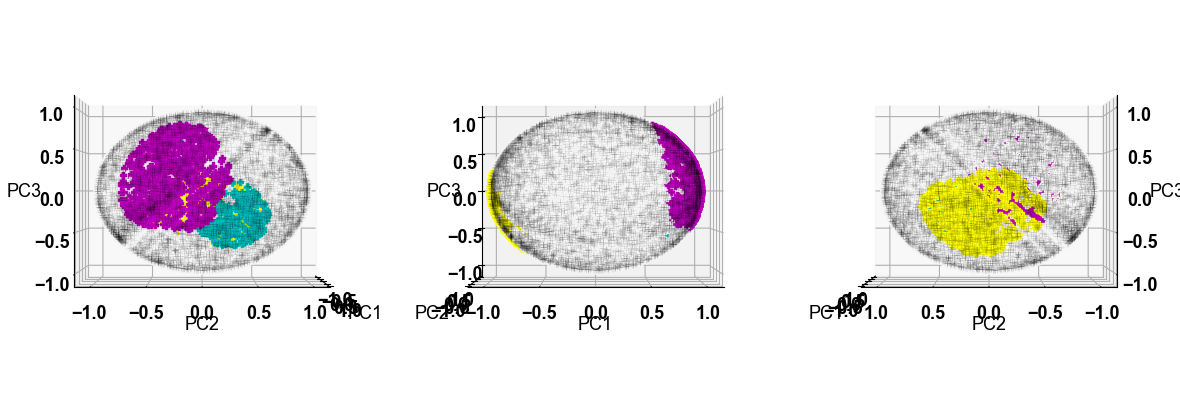

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), subplot_kw=dict(projection='3d'))
fig.subplots_adjust(wspace=0, hspace=0)

rotate = [(0, 0), (270, 0), (180, 0)]
colors = list(map(lambda x: 
                  'm' if x == 0 else 
                  'c' if x == 1 else 
                  'yellow' if x == 2 else
                  'whitesmoke', labels_optics))

for i in range(len(rotate)):
    for index, class_value in enumerate(np.unique(labels_optics)):
        if class_value == 0:
            class_ = 'Low Perf.'
            
        elif class_value==1:
            class_ = 'Medium Perf.'
           
        else:
            class_ = 'High Perf.'
                   
        axs[i].scatter(
            normalize(X)[:, 0], 
            normalize(X)[:, 1], 
            normalize(X)[:, 2], 
            c=colors, alpha=1, marker='P')
        axs[i].scatter(
            normalize(X)[:, 0], 
            normalize(X)[:, 1], 
            normalize(X)[:, 2], 
            c='k', alpha=.1, marker='+', lw=.5)
        axs[i].view_init(azim=rotate[i][0], elev=rotate[i][1])
        axs[i].set_xlabel('PC1'), axs[i].set_ylabel('PC2'), axs[i].set_zlabel('PC3')

plt.tight_layout()
plt.show();

All distances are added to an ordered list, containings reachability distances in an ascending way.

In [45]:
# Creating a numpy array with numbers at equal spaces till 
# the specified range 
space = np.arange(len(normalize(X))) 

# Storing the reachability distance of each point 
reachability = optics_predict.reachability_[optics_predict.ordering_] 

# Storing the cluster labels of each point 
labels_optics = optics_predict.labels_[optics_predict.ordering_] 


This ordered list is displayed in the image below, a so-called reachability plot. In this plot, the reachability distances for each point are mapped. 

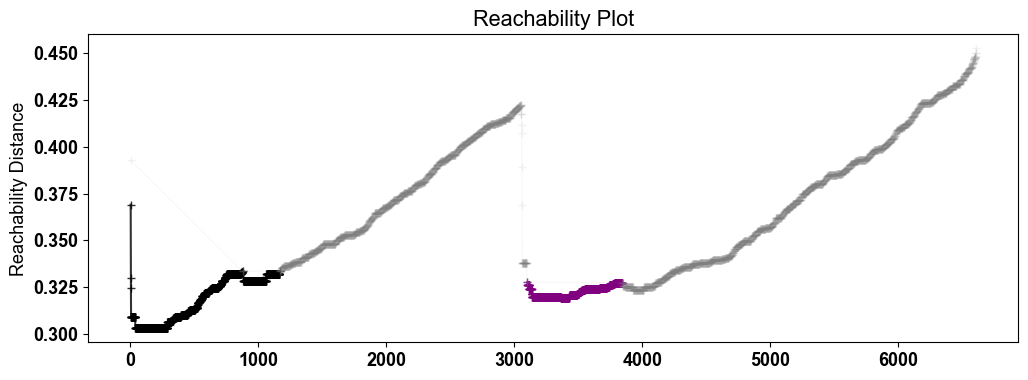

In [47]:
# Plotting the Reachability-Distance Plot 
fig = plt.figure(figsize=(12, 4))

colors = list(map(lambda x: 
                  'purple' if x == 0 else 
                  'darkorange' if x == 1 else 
                  'Yellow' if x == 2 else
                  'k', labels_optics))

for class_, colour in enumerate(colors): 
	xc = space[labels_optics == class_] 
	rc = reachability[labels_optics == class_] 
	plt.plot(xc, rc, colour, marker='+', alpha=.8) 

plt.plot(space[labels_optics == -1], 
         reachability[labels_optics == -1], 'grey', marker='+', lw=.5, alpha=.1) 
plt.ylabel('Reachability Distance') 
plt.title('Reachability Plot') 
plt.show();

Clearly, from one point, we can see how the clusters have been extended in a reachability distance-based ascending ordering. The valleys represent clusters and can be considered as being clusters, whereas the peaks represent the cutoff points, sometimes even with outliers in between.

### Anomaly detection

OPTICS is primarily a clustering algorithm, but it can be adapted for anomaly detection.

We will consider 99.5% of the data as normal, and the remaining portion will be classified as outliers. With this threshold value, we will identify samples with scores equal to or higher than the threshold.

In [51]:
# Define the model 
optics_anomaly = OPTICS(metric='euclidean').fit(X)
 
# Get core distances 
scores = optics_anomaly.core_distances_ 
 
# Set a threshold  
thresh = np.quantile(scores, .995)

In [52]:
# Identify anomalies  
index = np.where(scores >= thresh)
values = X[index] 

In [53]:
print('\033[1m \bAnomal points: \033[0m \n')
print(values)

Anomal points:  

[[ 0.33899728  3.32672013  2.34372472]
 [ 6.36836536 -0.61145886  1.67853153]
 [ 4.30640483  0.13942186 -0.31951864]
 ...
 [ 7.1224273   1.5086365  -0.14705551]
 [ 5.55983122  1.44769831  0.15292089]
 [ 5.59496782  1.286255    0.95980657]]


## Implementing K-Means++ model

At first, we use the elbow criterion. This method is a heuristic used in determining the optimal number of clusters into which the data may be clustered.

  File "C:\Users\UTENTE\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


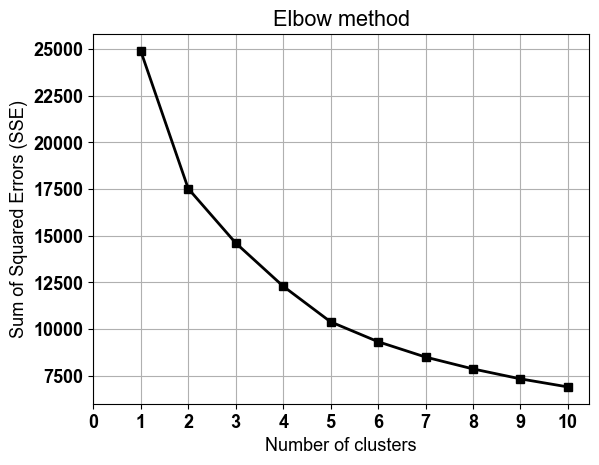

In [56]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, 'k', lw=2, marker='s')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0, 11, 1))
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid()
plt.show();

The optimal number of clusters is the number that appear just post to the elbow (in this case, 3).

### Lloyd’s algorithm

To build the K-Means++ model, using Lloyd’s algorithm, we can follow the following steps:

- __1.__ initialize the centroids using K-Means++
- __2.__ assign each point to the nearest centroid
- __3.__ update the centroids based on the assigned points

Repeat steps __2.__ and __3.__ until convergence.

&nbsp; 

__Strategy__

The random points are selected from the dataset and used as the initial centroids (__1.__). This is an approach where the selected centroids are not well positioned throughout the entire data space.

The algorithm assigns the first centroid to the location of a randomly selected point, and then choosing the subsequent centroids from the remaining points based on a probability proportional to the squared distance away from nearest existing centroid (__2.__ and __3.__). 

The effect is an attempt to push the centroids as far from one another as possible, covering as much of the occupied data space.

&nbsp; 

__Algorithm__

We have created a class named `KmeansPlusPlus` to execute our own clustering task. The class has these functions:
- `initialize_centroids` uses the K-Means++ method to choose initial centroids
- `predict` assigns data points to the nearest centroid and updates the centroids until convergence is reachehed.

In [60]:
class KmeansPlusPlus:
    '''
    K-means problem using Lloyd's algorithm
    -----------
    Parameters:
        n_clusters: int, number of clusters
        max_iterations: int, maximum number of iterations
        metric: str, Compute distance between each pair of points.
                The distance metric to use: 'chebyshev', 'cosine', 'dice', 
                'euclidean', 'hamming', 'mahalanobis', 'minkowski', ecc.
                (cdist() method of the module scipy.spatial.distance)
    '''
    
    def __init__(self, n_clusters: int, max_iterations: int, metric: str):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.metric = metric
    
    def initialize_centroids(self, X):
        '''
        Choose initial centroids that are spread out.
        -----------
        Return value: an array of centroids, representing the mean of the dinstances of each cluster.
        '''
        
        # randomly initialized centroids
        centroids = [X[np.random.randint(X.shape[0])]]
        
        for _ in range(1, self.n_clusters):
            # probability proportional to the squared distance 
            # away from a given point nearest existing centroid
            dist_sq = np.min(cdist(X, np.array(centroids))**2, axis=1)
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = np.cumsum(probs)
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(X[j])
                    break
        
        return np.array(centroids)

    def predict(self, X):
        '''
        assign each point to the nearest centroid and updates the centroids until the maximum number of iterations.
        -----------
        Return value: two arrays, one of the updated centroids, and onther one containings the predicted labels.
        '''
        
        # initialized centroids located  
        # one in each of the clusters
        centroids = self.initialize_centroids(X)
        
        for _ in range(self.max_iterations):
            # compute distance 
            distances = cdist(X, centroids, self.metric)
            labels = np.argmin(distances, axis=1)
            
            # re-calculated centroids becoming the new centers of their respective clusters
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids
        
        return labels, centroids

In [61]:
model = KmeansPlusPlus(n_clusters=3, max_iterations=300, metric='euclidean')
labels_kmeans, \
        centroids = model.predict(X)

### Visualizing the results

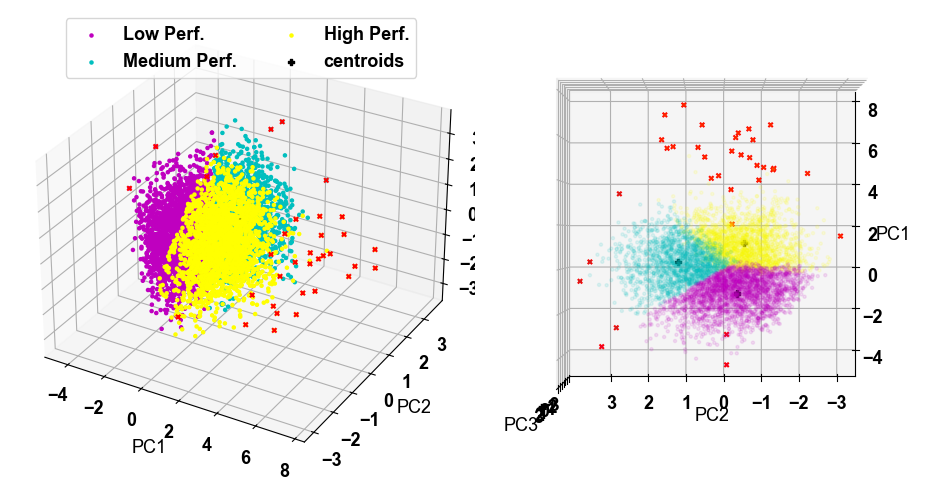

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(projection='3d'))
fig.subplots_adjust(wspace=0, hspace=0)

rotate = [(None, None), (180, 90)]
colormap = ListedColormap(['m', 'c', 'yellow'])

opacity = 1
for i in range(len(rotate)):
    if i == 1:
        opacity = .1
    for index, class_value in enumerate(np.unique(labels_kmeans)):
        if class_value == 0:
            class_ = 'Low Perf.'
            
        elif class_value==1:
            class_ = 'Medium Perf.'
           
        else:
            class_ = 'High Perf.'
        axs[i].scatter(
            X[labels_kmeans == class_value, 0], 
            X[labels_kmeans == class_value, 1], 
            X[labels_kmeans == class_value, 2], 
            color=colormap(index), alpha=opacity, label=class_, marker='.')
        
    axs[i].scatter(values[:, 0], values[:, 1], values[:, 2], c='r', alpha=1, s=10, marker='x')
    axs[i].scatter(centroids[:, 0], centroids[:, 1],  centroids[:, 2], c='k', marker='P', alpha=1, label='centroids')
    
    axs[i].view_init(azim=rotate[i][0], elev=rotate[i][1])
    axs[i].set_xlabel('PC1'), axs[i].set_ylabel('PC2'), axs[i].set_zlabel('PC3')

axs[0].legend(loc='upper center', ncol=2)    
plt.show();

## Evaluation metrics

The evaluation metrics play a pivotal role in evaluating the effectiveness of machine learning algorithms. The clustering metrics provide quantitative measures to assess the quality of clusters formed. By gauging factors like similarity, homogeneity, and separation, clustering metrics such as Rand Index, Mututal Information Index, and Fowlkes–Mallows index offer informations into the performance of clustering techniques.

&nbsp; 

__Rand Index (Raw)__ compares findings from clustering to a ground truth in order to assess how accurate the results are. It evaluates whether data point pairs are clustered together or apart in both the true and anticipated clusterings. The raw RI score is:

$$RRI = \frac{\# \text{ agreeing pairs} }{\# \text{ pairs} }$$

__RRI__ produces a value between 0 and 1 inclusive; 1 stands for perfect match.

&nbsp; 

__Rand Index (Adjusted)__ The Raw RI score is "_adjusted for chance_" using the following formula:

$$ARI = \frac{RI-\mathbb{E}(RI)}{\max RI-\mathbb{E}(RI)}$$

where $\mathbb{E}(RI)$ is the expected value of the Rand Index.

It ranges from -1 to 1, where 1 indicates perfect clustering, values close 0 indicates random clustering (random labeling independently of the number of clusters), and negative values suggest poor clustering (heavily discordant).

&nbsp; 

__Mutual Information Index__ measures the degree to which the knowledge of one variable reduces uncertainty about the other. It evaluates the degree of agreement between the actual and expected cluster designations in the context of clustering evaluation, hence capturing the quality of outcomes. MII between true labels Y and predicted labels Z is calculated as:

$$MII(Y,Z) = \sum_{i=1}^{|Y|}\sum_{j=1}^{|Z|} \frac{|Y_i \cap Z_j|}{N} \log \frac{N |Y_i \cap Z_j|}{|Y_i| |Z_j|}$$

where $|Y_i|$ is the number of the samples in set of true labels and $|Z_j|$ is the number of the samples in set of predict labels.

The values of Mutual Information Index range from 0 to infinity. High scores signify more mutual information, indicating better agreement between clusters and true labels; values close to zero denotes no agreement. It provides a reliable indicator of how closely anticipated and actual labels match up.

&nbsp; 

__Silhouette Score__ is employed to assess a dataset's well-defined clusters, quantifiyng the separation between clusters. It for a data point i is calculated as:

$$S(i) = \frac{b(i)-a(i)}{\max\{a(i),b(i)\}}$$

where $b(i)$ is the average distance of $i\text{-th}$ point with all points in the nearest cluster and, $a(i)$ is the average distance of $i\text{-th}$ point to all other points in its own cluster.

It ranges from -1 to 1. The best value is 1 (the point is well-matched to its own cluster) and the worst value is -1(the point might be in the incorrect cluster). Values near 0 indicate overlapping clusters.

&nbsp; 

__Fowlkes–Mallows Index__ measures the pairwise similarity of clusters of a set of points. It is defined as the geometric mean between of the precision and recall:

$$FMI = \frac{TP}{\sqrt{(TP + FP) \cdot (TP + FN)}}$$

Where $TP$ is the number of true positive (i.e. the number of pairs of labels that belong to both true labels and predict labels), $FP$ is the number of false positive (i.e. the number of pairs of labels that belong to predict labels but not to true labels) and $FN$ is the number of false negative (i.e. the number of pairs of labels that belong to true labels but not to pred labels).

The score ranges from 0 to 1. A high value indicates a good similarity between the clusters.

In [66]:
RRI = dict(
    OPTICS=rand_score(labels_true=Y.flatten(), labels_pred=labels_optics),
    KMeans=rand_score(labels_true=Y.flatten(), labels_pred=labels_kmeans)
)
ARI = dict(
    OPTICS=adjusted_rand_score(labels_true=Y.flatten(), labels_pred=labels_optics),
    KMeans=adjusted_rand_score(labels_true=Y.flatten(), labels_pred=labels_kmeans)
)
MMI = dict(
    OPTICS=mutual_info_score(labels_true=Y.flatten(), labels_pred=labels_optics),
    KMeans=mutual_info_score(labels_true=Y.flatten(), labels_pred=labels_kmeans)
)
Sil = dict(
    OPTICS=silhouette_score(X=X, labels=labels_optics),
    KMeans=silhouette_score(X=X, labels=labels_kmeans)
)
FMI = dict(
    OPTICS=fowlkes_mallows_score(labels_true=Y.flatten(), labels_pred=labels_optics),
    KMeans=fowlkes_mallows_score(labels_true=Y.flatten(), labels_pred=labels_kmeans)
)

In [67]:
objects = globals()
metrics = ['RRI', 'ARI', 'MMI', 'Sil', 'FMI']


results = {}
optics_, kmeans_ = [], []
for Model in ['OPTICS', 'KMeans']:
    for m in metrics:
        if Model == 'OPTICS':
            optics_.append(objects.get(m).get(Model))
            results[Model] = [f'{v:.3f}' for v in optics_]
        else:
            kmeans_.append(objects.get(m).get(Model))
            results[Model] = [f'{v:.3f}' for v in kmeans_]

print('\033[1m \bClustering metrics: \033[0m \n')
print(pd.DataFrame(data=results, index=metrics))

Clustering metrics:  

     OPTICS KMeans
RRI   0.516  0.480
ARI  -0.004  0.088
MMI   0.001  0.123
Sil  -0.017  0.242
FMI   0.624  0.549


### Interpret the metrics

- __RRI__ a rating of 0.52 shows that the clustering findings and the actual class labels correspond averagely well. K-Means performs slightly less than OPTICS.

- __ARI__ Furthermore, K-Means tends to be more subject to random effect than OPTICS (ARI≈0.09).
- __MMI__ Low values of MMI indicates a poor amount of shared information between the true labels and the predicted assigned by both the algorithm. It signifies that the clustering solution captures a insignificant portion of the underlying structure in the data, not aligning well with the actual class labels.
- __S(i)__ The results indicate that there is very little separation between the clusters, or there is some overlapping between clusters.
- __FMI__ The values of 0.62 and 0.55 for OPTICS and Kmeans respectively, suggest the some similarity exists between the clusters. 